In [1]:
import sys
import os

# Add the directory containing your modules to the system path
# sys.path.insert(0, os.path.abspath('/projects/e32704/andy/decisionmaking/gridworld-decisionmaking/Simulation 2 Pseudo-Terrestrial/planning'))

In [35]:
import pickle as pkl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation
from pathlib import Path

In [4]:
from game import Game
from simulator import Knowledge
# from mcts import SearchParams, UnitTestMCTS
from experiment import ExperimentParams, ExperimentParamsOld, Experiment
from entropy import UnitTestENTROPY
from utils import UnitTestUTILS, Random
from coord import COORD, UnitTestCOORD, COMPASS, ManhattanDistance, Compass, LineCoordinates
from grid import Grid
from entropy import Entropy
from astar import AStar
from math import floor
from time import time

In [5]:
XSize = 15
YSize = 15
AgentHome = COORD(7, 0)
GoalPos = COORD(floor(XSize/2), YSize-1)
visualRange = None


treeknowlege = 2 # 0 = pure, 1 = legal, 2 = smart
rolloutknowledge = 2 # 0 = pure, 1 = legal, 2 = smart
smarttreecount = 1.0 # prior count for preferred actions in smart tree search
smarttreevalue = 1.0 # prior value for preferred actions during smart tree search

In [160]:
OUTPUT_LOC = Path('/projects/e32704/andy/decisionmaking/gridworld-decisionmaking/Simulation 2 Pseudo-Terrestrial/planning/figures')

In [204]:
e07.groupby('outcome')

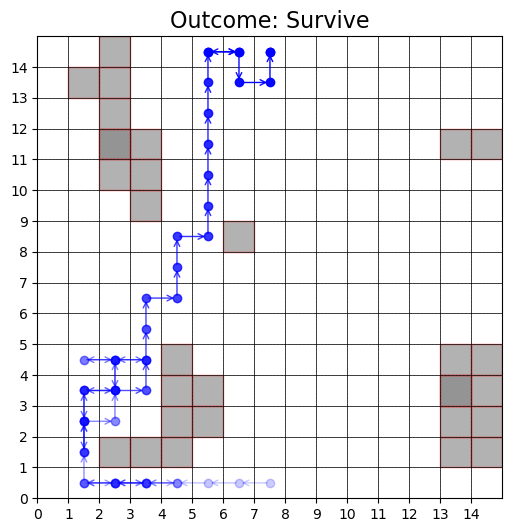

In [264]:
draw_grid(o05, e05, 'Non-Auditory', 5, 1, save=True)

IndexError: list index out of range

Error in callback <function _draw_all_if_interactive at 0x7fcbc2063ec0> (for post_execute), with arguments args (),kwargs {}:


RuntimeError: x must be a sequence

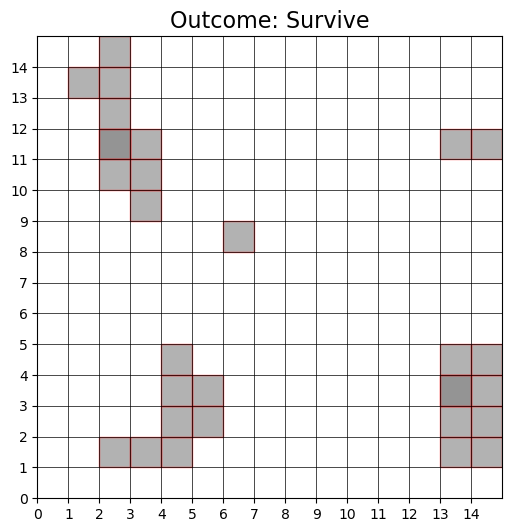

In [270]:
anim = draw_grid_animation(o05, e05, 'Non-Auditory', 5, 1, True)

In [265]:
def draw_grid_animation(occlusion_df, episode_df, auditory_type, entropy, episode, save=False):
    # Define grid size
    xdim, ydim = 15, 15
    grid_size = (xdim, ydim)

    # Get the episode data
    e_df = episode_df[episode_df['episode'] == episode]

    # Extract positions
    prey_positions = e_df[['Agent X', 'Agent Y']].values

    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(6, 6))

    # Draw the grid
    for x in range(grid_size[0] + 1):
        ax.plot([x, x], [0, grid_size[1]], 'k', linewidth=0.5)  # Vertical lines
    for y in range(grid_size[1] + 1):
        ax.plot([0, grid_size[0]], [y, y], 'k', linewidth=0.5)  # Horizontal lines

    # Add occlusions
    for _, row in occlusion_df.iterrows():
        rect = patches.Rectangle((row['X'], row['Y']), 1, 1, linewidth=1, edgecolor='r', facecolor='gray', alpha=0.6)
        ax.add_patch(rect)

    # Labels and limits
    ax.set_xlim(0, grid_size[0])
    ax.set_ylim(0, grid_size[1])
    ax.set_xticks(np.arange(0, grid_size[0], 1))
    ax.set_yticks(np.arange(0, grid_size[1], 1))
    ax.set_xticklabels(np.arange(0, grid_size[0], 1))
    ax.set_yticklabels(np.arange(0, grid_size[1], 1))
    ax.set_title(f"Outcome: {e_df.iloc[0]['outcome']}", fontsize=16)

    # Initialize prey scatter plot and arrow
    prey_dot, = ax.plot([], [], 'bo', markersize=6, label="Prey")
    prey_arrow = ax.annotate("", xy=(0, 0), xytext=(0, 0),
                             arrowprops=dict(facecolor='blue', edgecolor='blue', arrowstyle='->'))

    # Animation update function
    def update(frame):
        x, y = prey_positions[frame]
        prey_dot.set_data(x + 0.5, y + 0.5)
        
        if frame > 0:
            prev_x, prev_y = prey_positions[frame - 1]
            prey_arrow.set_position((prev_x + 0.5, prev_y + 0.5))
            prey_arrow.xy = (x + 0.5, y + 0.5)
        return prey_dot, prey_arrow

    # Create animation
    ani = animation.FuncAnimation(fig, update, frames=len(prey_positions), interval=300, blit=False)

    # Save as GIF if required
    if save:
        gif_filename = f"{auditory_type}_{entropy}_{episode}.gif"
        ani.save(gif_filename, writer=animation.PillowWriter(fps=5))
        print(f"Saved GIF: {gif_filename}")
    else:
        plt.show()


In [262]:
def draw_grid(occlusion_df, episode_df, auditory_type, entropy, episode, save=False):
    # Define grid size
    xdim, ydim = 15, 15
    grid_size = (xdim, ydim)

    # get current episode
    e_df = episode_df[episode_df['episode'] == episode]

    # extract positions
    predator_positions = e_df[['Predator X', 'Predator Y']].values
    prey_positions = e_df[['Agent X', 'Agent Y']].values
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(6, 6))
    
    # Draw the grid
    for x in range(grid_size[0] + 1):
        ax.plot([x, x], [0, grid_size[1]], 'k', linewidth=0.5)  # Vertical lines
    for y in range(grid_size[1] + 1):
        ax.plot([0, grid_size[0]], [y, y], 'k', linewidth=0.5)  # Horizontal lines
    
    # Add occlusions
    for _, row in occlusion_df.iterrows():
        # print(type(row))
        rect = patches.Rectangle((row['X'], row['Y']), 1, 1, linewidth=1, edgecolor='r', facecolor='gray', alpha=0.6)
        ax.add_patch(rect)

    # get the number of simulated steps
    num_steps = e_df.shape[0]
    colors = np.linspace(0.2, 1, num_steps)

    # plot prey positions
    for i, (x, y) in enumerate(prey_positions):
        ax.scatter(x + 0.5, y + 0.5, color=(0, 0, 1, colors[i]), label='Prey' if i == 0 else "")
        if i > 0:  # Draw arrow from the previous position to the current position
            prev_x, prev_y = prey_positions[i - 1]
            ax.annotate('', xy=(x + 0.5, y + 0.5), xytext=(prev_x + 0.5, prev_y + 0.5),
                        arrowprops=dict(facecolor='blue', edgecolor='blue', arrowstyle='->', alpha=colors[i]))

    
    # # plot pred positions
    # for i, (x, y) in enumerate(predator_positions):
    #     ax.scatter(x + 0.5, y + 0.5, color=(1, 0, 0, colors[i]), label='Predator' if i == 0 else "")
    #     if i > 0:  # Draw arrow from the previous position to the current position
    #         prev_x, prev_y = predator_positions[i - 1]
    #         ax.annotate('', xy=(x + 0.5, y + 0.5), xytext=(prev_x + 0.5, prev_y + 0.5),
    #                     arrowprops=dict(facecolor='red', edgecolor='red', arrowstyle='->', alpha=colors[i]))

    # Labels and limits
    ax.set_xlim(0, grid_size[0])
    ax.set_ylim(0, grid_size[1])
    ax.set_xticks(np.arange(0, grid_size[0], 1))
    ax.set_yticks(np.arange(0, grid_size[1], 1))
    ax.set_xticklabels(np.arange(0, grid_size[0], 1))
    ax.set_yticklabels(np.arange(0, grid_size[1], 1))
    ax.set_title(f"Outcome: {e_df.iloc[0]['outcome']}", fontsize=16)
    
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    if save:
        plt.savefig(OUTPUT_LOC.joinpath(f"{auditory_type}_{entropy}_{episode}.png"))
    else:
        plt.show()

In [235]:
def draw_grid_alltrials(occlusion_df, episode_df, entropy, auditory_type, save=False):
    # Define grid size
    xdim, ydim = 15, 15
    grid_size = (xdim, ydim)

    episodes = np.sort(episode_df['episode'].unique())
    
    # Create the plot
    fig, axes = plt.subplots(1, len(episodes), figsize=(5 * len(episodes), 6))

    for episode in episodes:
        ax = axes[episode]
        
        # get current episode
        e_df = episode_df[episode_df['episode'] == episode]
    
        # extract positions
        predator_positions = e_df[['Predator X', 'Predator Y']].values
        prey_positions = e_df[['Agent X', 'Agent Y']].values
        
        # Draw the grid
        for x in range(grid_size[0] + 1):
            ax.plot([x, x], [0, grid_size[1]], 'k', linewidth=0.5)  # Vertical lines
        for y in range(grid_size[1] + 1):
            ax.plot([0, grid_size[0]], [y, y], 'k', linewidth=0.5)  # Horizontal lines
        
        # Add occlusions
        for _, row in occlusion_df.iterrows():
            # print(type(row))
            rect = patches.Rectangle((row['X'], row['Y']), 1, 1, linewidth=1, edgecolor='r', facecolor='gray', alpha=0.6)
            ax.add_patch(rect)
    
        # get the number of simulated steps
        num_steps = e_df.shape[0]
        colors = np.linspace(0.2, 1, num_steps)
    
        # plot prey positions
        for i, (x, y) in enumerate(prey_positions):
            ax.scatter(x + 0.5, y + 0.5, color=(0, 0, 1, colors[i]), label='Prey' if i == (len(prey_positions)-1) else "")
            if i > 0:  # Draw arrow from the previous position to the current position
                prev_x, prev_y = prey_positions[i - 1]
                ax.annotate('', xy=(x + 0.5, y + 0.5), xytext=(prev_x + 0.5, prev_y + 0.5),
                            arrowprops=dict(facecolor='blue', edgecolor='blue', arrowstyle='->', alpha=colors[i]))
    
        
        # plot pred positions
        for i, (x, y) in enumerate(predator_positions):
            ax.scatter(x + 0.5, y + 0.5, color=(1, 0, 0, colors[i]), label='Predator' if i == (len(predator_positions)-1) else "")
            if i > 0:  # Draw arrow from the previous position to the current position
                prev_x, prev_y = predator_positions[i - 1]
                ax.annotate('', xy=(x + 0.5, y + 0.5), xytext=(prev_x + 0.5, prev_y + 0.5),
                            arrowprops=dict(facecolor='red', edgecolor='red', arrowstyle='->', alpha=colors[i]))
    
        # Labels and limits
        ax.set_xlim(0, grid_size[0])
        ax.set_ylim(0, grid_size[1])
        ax.set_xticks(np.arange(0, grid_size[0], 1))
        ax.set_yticks(np.arange(0, grid_size[1], 1))
        ax.set_xticklabels(np.arange(0, grid_size[0], 1))
        ax.set_yticklabels(np.arange(0, grid_size[1], 1))
        ax.set_aspect('equal')
        ax.set_title(f"Outcome: {e_df.iloc[0]['outcome']}", fontsize=20)

    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    fig.suptitle(f"{auditory_type}, Entropy: {round(entropy/10, 1)}", fontsize=20)
    plt.tight_layout()

    if save:
        plt.savefig(OUTPUT_LOC.joinpath(f"{auditory_type}_{entropy}.png"))
    else:
        plt.show()

In [222]:
def get_audio_occlusion_episode_df(data_loc):
    # data_loc should be of type path
    # returns occlusion and epi
    dfs = []
    for i, dir in enumerate(data_loc.glob('*')):
        id = int(dir.stem.split("_")[-1])
        csvpath = dir.joinpath('Occlusion_0', 'Predator_0', 'Depth_100', 'Episode_0.csv')
        df = pd.read_csv(csvpath)
        df['episode'] = id
        dfs.append(df)
        if i == 0:
            o_df = pd.read_csv(dir.joinpath('Occlusion_0', 'OcclusionCoordinates.csv'))
    combined = pd.concat(dfs, ignore_index=True)
    # create extra variables
    last_vals = combined.groupby('episode')['Reward'].transform('last')
    combined['outcome'] = np.select(
        [
            last_vals > 5,
            (last_vals >= -5) & (last_vals <= 5),
            last_vals < -5,
        ],
        [
            'Survival',
            'Tie',
            'Death',
        ]
    )
    return (o_df, combined)

In [221]:
def get_episode_df(episode_loc):
    # episode_loc should be of type path
    dfs = []
    for csv_file in episode_loc.glob("Episode_*.csv"):
        id = int(csv_file.stem.split("_")[-1])
        df = pd.read_csv(csv_file)
        df['episode'] = id
        dfs.append(df)
    combined = pd.concat(dfs, ignore_index=True)

    # create extra variables
    last_vals = combined.groupby('episode')['Reward'].transform('last')
    combined['outcome'] = np.select(
        [
            last_vals > 5,
            (last_vals >= -5) & (last_vals <= 5),
            last_vals < -5,
        ],
        [
            'Survival',
            'Tie',
            'Death',
        ]
    )
    return combined

In [241]:
ae05.groupby('episode').first()['outcome'].value_counts()

outcome
Death    4
Tie      1
Name: count, dtype: int64

In [245]:
t = ae05.groupby('episode').first()['outcome']

In [250]:
t[t=='Survival'].shape

(0,)

In [253]:
ae05.columns

Index(['Action', 'Agent X', 'Agent Y', 'Audio Observation', 'Observation',
       'Predator X', 'Predator Y', 'Reward', 'episode', 'outcome'],
      dtype='object')

In [252]:
res = [ae05, ae07, e05, e07]

In [256]:
ress = [r.groupby('episode').last()['Reward'] for r in res]

In [257]:
ress

[episode
 0     -1
 1   -101
 2   -101
 3   -101
 4   -101
 Name: Reward, dtype: int64,
 episode
 0   -101
 1     -1
 2     -1
 3   -101
 4   -101
 Name: Reward, dtype: int64,
 episode
 0   -101
 1    999
 2   -101
 3   -126
 4   -101
 Name: Reward, dtype: int64,
 episode
 0   -101
 1     -1
 2   -101
 3   -101
 4     -1
 Name: Reward, dtype: int64]

In [255]:
resss = [r[[

[         Action  Agent X  Agent Y  Audio Observation  Observation  Predator X  \
 episode                                                                         
 0             1        1        2                  0            0           6   
 1             0        4        8                  0            1           4   
 2             3       11        0                  0            1          11   
 3             0        0        3                  0            1           0   
 4             0        5        8                  0            1           5   
 
          Predator Y  Reward outcome  
 episode                              
 0                 1      -1     Tie  
 1                 8    -101   Death  
 2                 0    -101   Death  
 3                 3    -101   Death  
 4                 8    -101   Death  ,
          Action  Agent X  Agent Y  Audio Observation  Observation  Predator X  \
 episode                                                            

In [ ]:
def plot_outcome_barplots(ae5, ae7, e5, e7):
    fig, axes = plt.subplots(1, 2)
    categories = ['Survived', 'Tie', 'Died']
    

    # left ax (0.5 entropy)
    ax = axes[0]
    outcomes = {
        'Death
    }
    ae5_outcomes = ae5.groupby('episode').first()['outcome']
    ax.bar(ae
    
    ax.set_title("Entropy: 0.5")


br1 = np.arange(len(IT)) 
br2 = [x + barWidth for x in br1] 
br3 = [x + barWidth for x in br2] 

plt.bar(br1, IT, color ='r', width = barWidth, 
        edgecolor ='grey', label ='IT') 
plt.bar(br2, ECE, color ='g', width = barWidth, 
        edgecolor ='grey', label ='ECE') 
plt.bar(br3, CSE, color ='b', width = barWidth, 
        edgecolor ='grey', label ='CSE') 

plt.xlabel('Branch', fontweight ='bold', fontsize = 15) 
plt.ylabel('Students passed', fontweight ='bold', fontsize = 15) 
plt.xticks([r + barWidth for r in range(len(IT))], 
        ['2015', '2016', '2017', '2018', '2019'])

plt.legend()
plt.show() 

## Notes

Data3 is a good test trial for the baseline, and it used 0.5 entropy over 5 episodes with the same predator location.

Data2 took a long time to run, but used 0.7 entropy over 5 episodes with the same predator location - it might be a better environment to discover the effects of audio

In [176]:
ae05.columns

Index(['Action', 'Agent X', 'Agent Y', 'Audio Observation', 'Observation',
       'Predator X', 'Predator Y', 'Reward', 'episode', 'outcome'],
      dtype='object')

In [177]:
ae05.Reward.unique()

array([   0,   -1, -101])

In [178]:
ae07.Reward.unique()

array([   0,   -1, -101])

In [179]:
e05.Reward.unique()

array([   0,   -1, -101, -126,  999])

In [180]:
e07.Reward.unique()

array([   0,   -1, -101])

In [182]:
ae05.groupby('episode').last().Reward

episode
0     -1
1   -101
2   -101
3   -101
4   -101
Name: Reward, dtype: int64

In [183]:
ae07.groupby('episode').last().Reward

episode
0   -101
1     -1
2     -1
3   -101
4   -101
Name: Reward, dtype: int64

In [184]:
e05.groupby('episode').last().Reward

episode
0   -101
1    999
2   -101
3   -126
4   -101
Name: Reward, dtype: int64

In [192]:
e07.groupby('episode').last()[['Reward', 'outcome', 'Predator X', 'Predator Y', 'Agent X', 'Agent Y']]

,Reward,outcome,Predator X,Predator Y,Agent X,Agent Y
episode,,,,,,
0,-101,Die,10,1,10,1
1,-1,Die,5,5,0,1
2,-101,Die,7,2,7,2
3,-101,Die,2,0,2,0
4,-1,Die,7,8,14,1


In [195]:
e05.Reward.unique()

array([   0,   -1, -101, -126,  999])

In [194]:
e07.Reward.unique()

array([   0,   -1, -101])

In [196]:
ae05.Reward.unique()

array([   0,   -1, -101])

In [197]:
ae07.Reward.unique()

array([   0,   -1, -101])

In [206]:
e07[e07['episode'] == 0]

,Action,Agent X,Agent Y,Observation,Predator X,Predator Y,Reward,episode,outcome
46,-1,7,0,-1,11,8,0,0,Tie
47,3,6,0,0,10,8,-1,0,Die
48,0,6,1,0,9,8,-1,0,Die
49,2,6,0,0,8,8,-1,0,Die
50,1,7,0,0,7,8,-1,0,Die
...,...,...,...,...,...,...,...,...,...
119,2,8,0,1,7,2,-1,0,Die
120,1,9,0,1,8,1,-1,0,Die
121,1,10,0,1,9,1,-1,0,Die
122,0,10,1,1,10,1,-101,0,Die


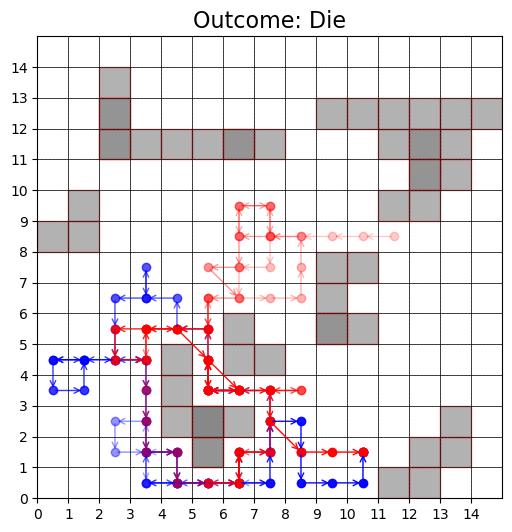

In [219]:
draw_grid(o07, e07, 0)

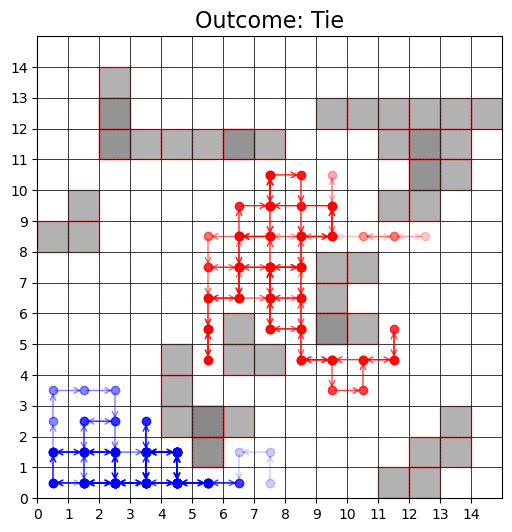

In [220]:
draw_grid(o07, e07, 1)

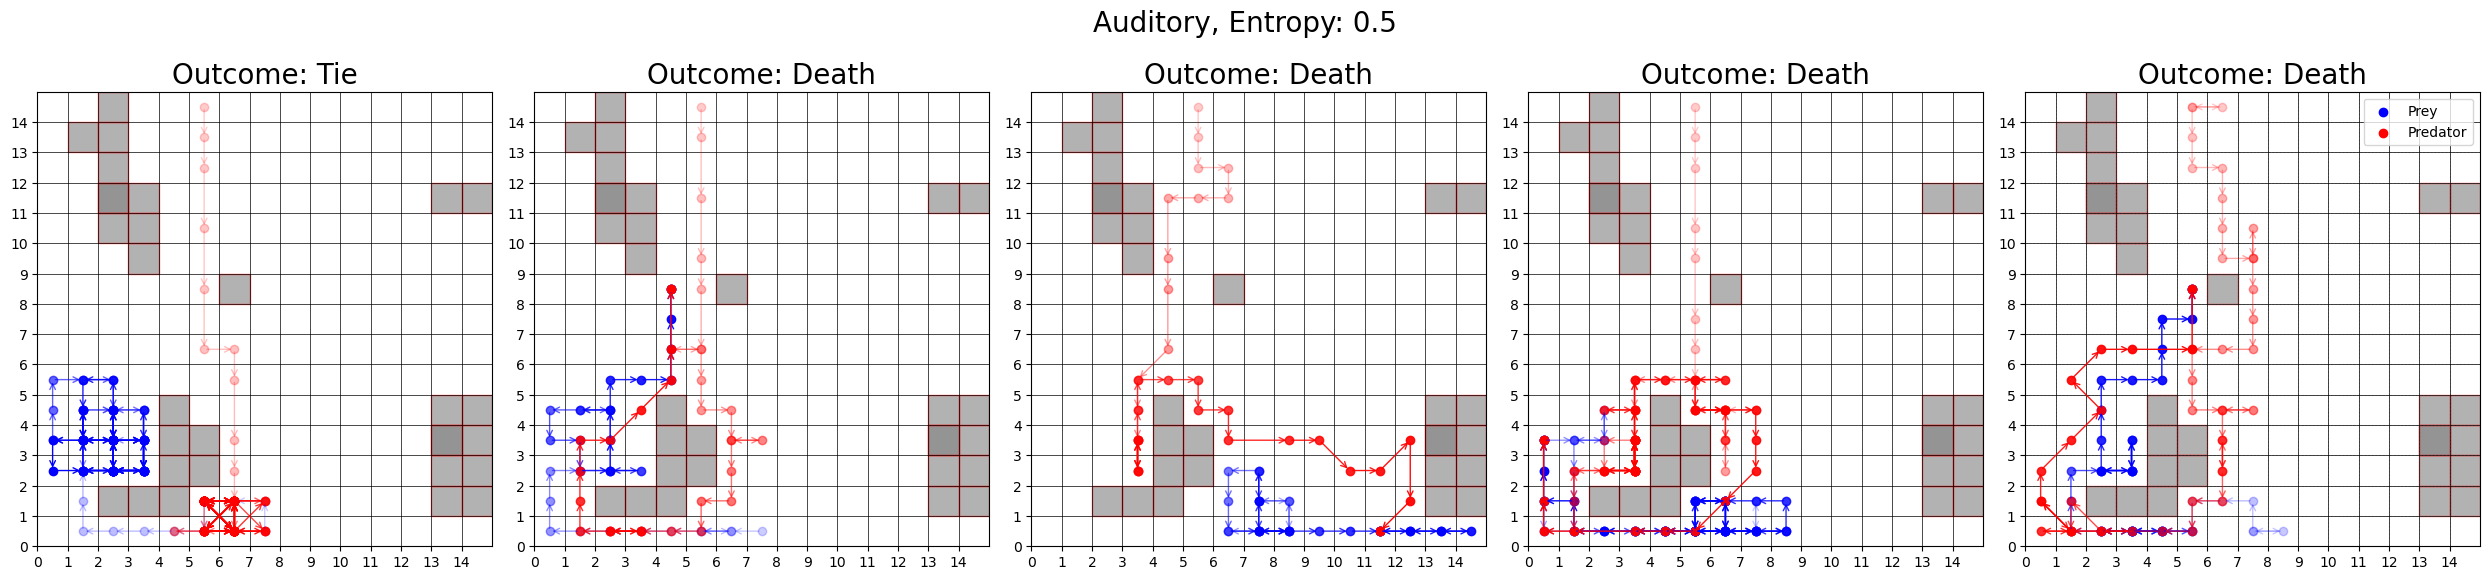

In [236]:
draw_grid_alltrials(
    ao05, ae05, 5, 'Auditory', 
    save=True
)

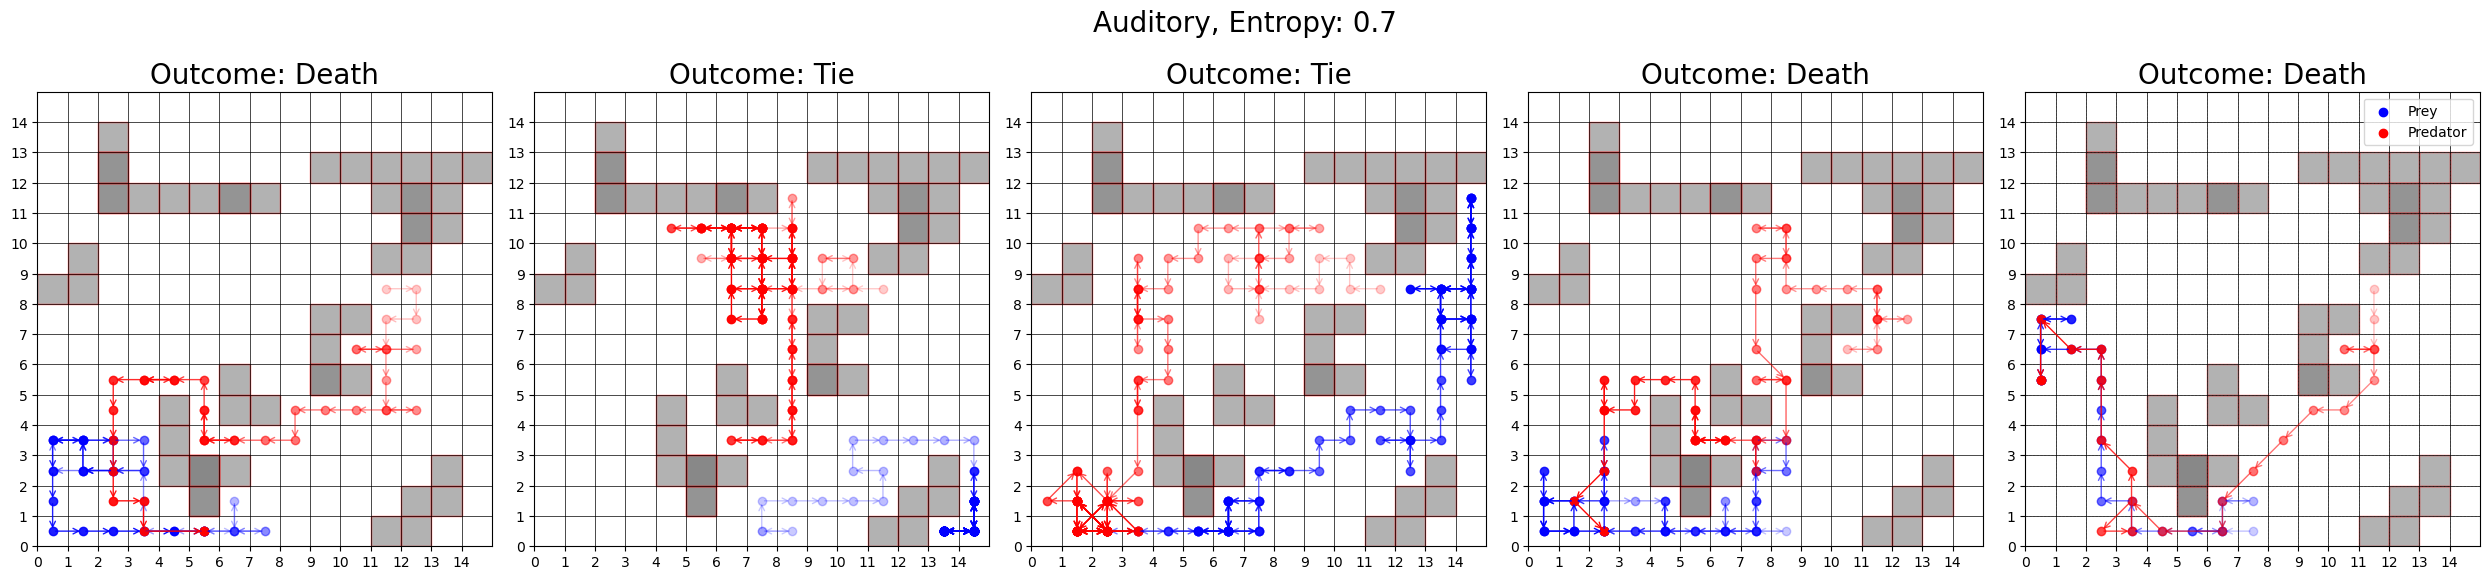

In [237]:
draw_grid_alltrials(
    ao07, ae07, 7, 'Auditory', 
    save=True
)

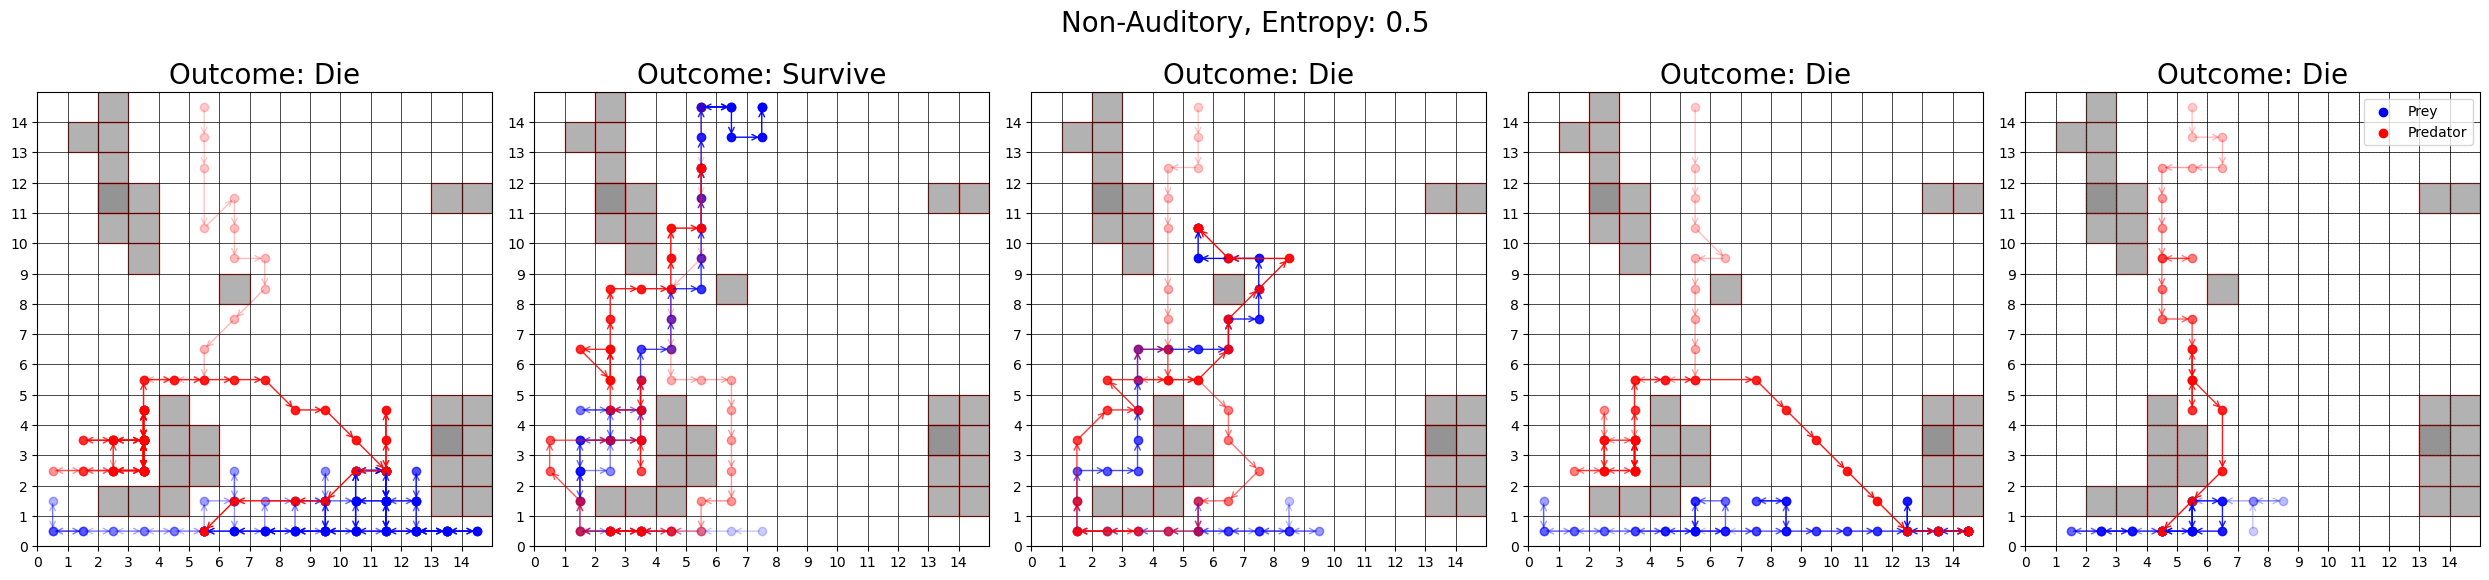

In [238]:
draw_grid_alltrials(
    o05, e05, 5, 'Non-Auditory', 
    save=True
)

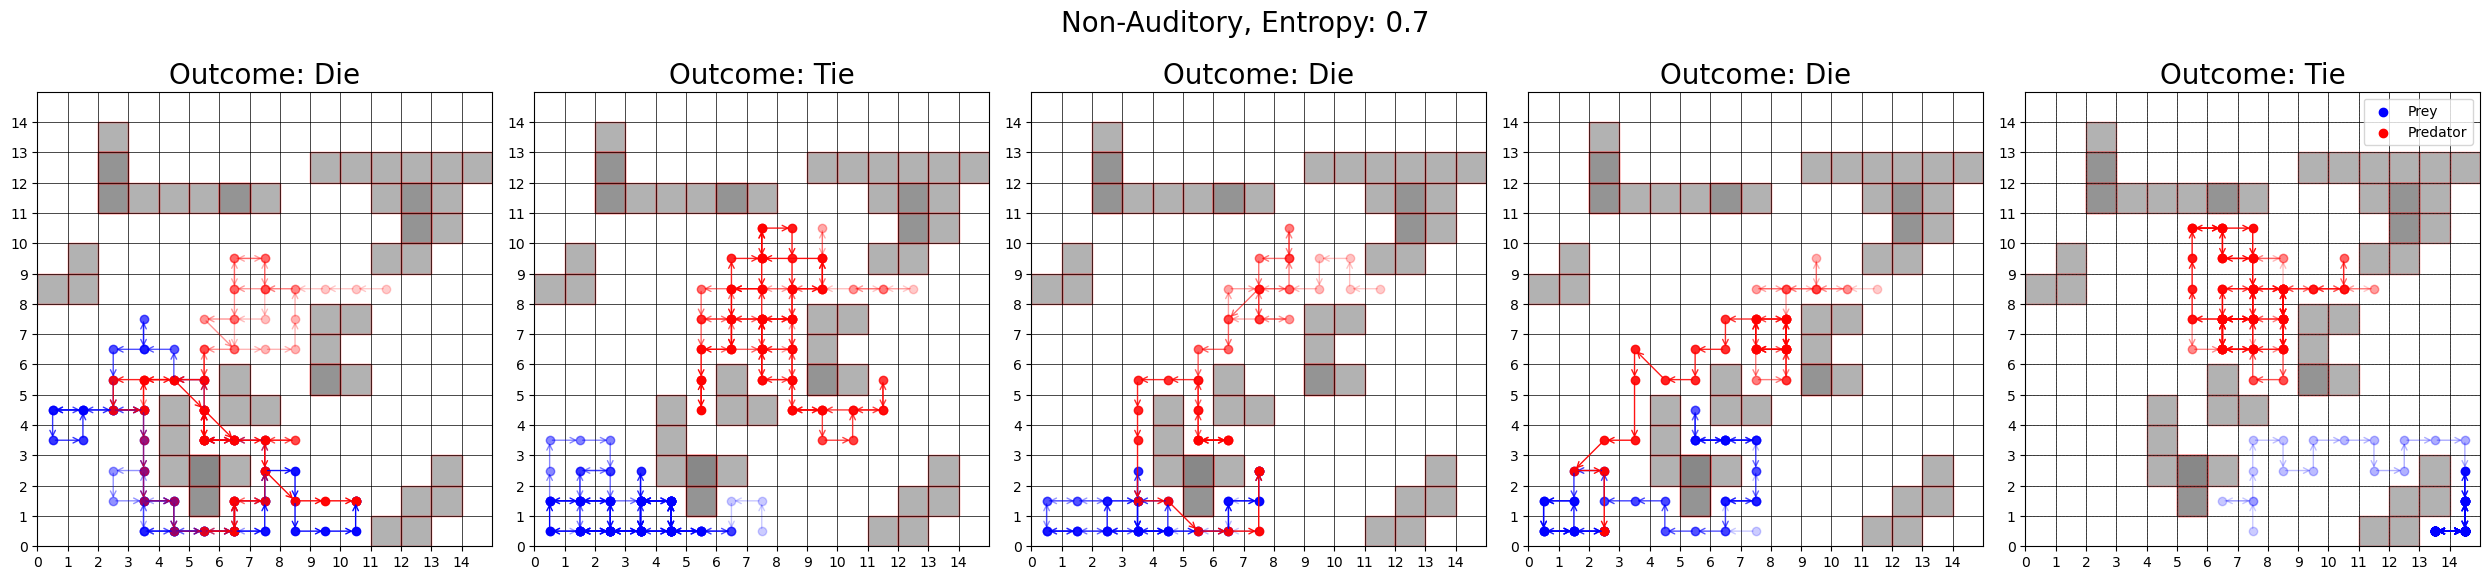

In [239]:
draw_grid_alltrials(
    o07, e07, 7, 'Non-Auditory',                 
    save=True
)

In [223]:
ao05, ae05 = get_audio_occlusion_episode_df(Path('/projects/e32704/andy/decisionmaking/gridworld-decisionmaking/Simulation 2 Pseudo-Terrestrial/planning/Data05'))
ao07, ae07 = get_audio_occlusion_episode_df(Path('/projects/e32704/andy/decisionmaking/gridworld-decisionmaking/Simulation 2 Pseudo-Terrestrial/planning/Data07'))

In [157]:
ae05['Audio Observation'].unique()

array([-1,  0])

In [158]:
ae07['Audio Observation'].unique()

array([-1,  0])

In [208]:
o05 = pd.read_csv('Data3/Simulation_0/Occlusion_0/OcclusionCoordinates.csv')
o07 = pd.read_csv('Data2/Simulation_0/Occlusion_0/OcclusionCoordinates.csv')
oD4 = pd.read_csv('Data4/Simulation_0/Occlusion_0/OcclusionCoordinates.csv')

In [115]:
csv0 = pd.read_csv("/projects/e32704/andy/decisionmaking/gridworld-decisionmaking/Simulation 2 Pseudo-Terrestrial/planning/Data3/Simulation_0/Occlusion_0/Predator_0/Depth_100/Episode_0.csv")

In [116]:
predator_start = COORD(*csv0.iloc[0][['Predator X', 'Predator Y']])

In [119]:
csv0.head()

,Action,Agent X,Agent Y,Observation,Predator X,Predator Y,Reward
0,-1,7,0,-1,5,14,0
1,1,8,0,0,5,13,-1
2,3,7,0,0,5,12,-1
3,3,6,0,1,5,10,-1
4,3,5,0,0,6,11,-1


In [118]:
print(predator_start)

(5;14)


In [218]:
e05_loc = Path('/projects/e32704/andy/decisionmaking/gridworld-decisionmaking/Simulation 2 Pseudo-Terrestrial/planning/Data3/Simulation_0/Occlusion_0/Predator_0/Depth_100')
e07_loc = Path('/projects/e32704/andy/decisionmaking/gridworld-decisionmaking/Simulation 2 Pseudo-Terrestrial/planning/Data2/Simulation_0/Occlusion_0/Predator_0/Depth_100')
eD4_loc = Path('/projects/e32704/andy/decisionmaking/gridworld-decisionmaking/Simulation 2 Pseudo-Terrestrial/planning/Data4/Simulation_0/Occlusion_0/Predator_0/Depth_100')

e05 = get_episode_df(e05_loc)
e07 = get_episode_df(e07_loc)
eD4 = get_episode_df(eD4_loc)

In [106]:
occlusions_lst = [COORD(row['X'], row['Y']) for _, row in o05.iterrows()]

In [107]:
print(occlusions_lst[0])

(3;9)


In [112]:
c = COORD(*e05.groupby('episode').first().iloc[0][['Predator X', 'Predator Y']])

In [114]:
print(c)

(5;14)


In [98]:
e07.groupby('episode').first()[['Agent X', 'Agent Y', 'Predator X', 'Predator Y', 'Reward']]

,Agent X,Agent Y,Predator X,Predator Y,Reward
episode,,,,,
0,7,0,11,8,0
1,7,0,11,8,0
2,7,0,11,8,0
3,7,0,11,8,0
4,7,0,11,8,0


In [78]:
e07.groupby('episode').last()[['Agent X', 'Agent Y', 'Predator X', 'Predator Y', 'Reward']]

,Agent X,Agent Y,Predator X,Predator Y,Reward
episode,,,,,
0,10,1,10,1,-101
1,0,1,5,5,-1
2,7,2,7,2,-101
3,2,0,2,0,-101
4,14,1,7,8,-1


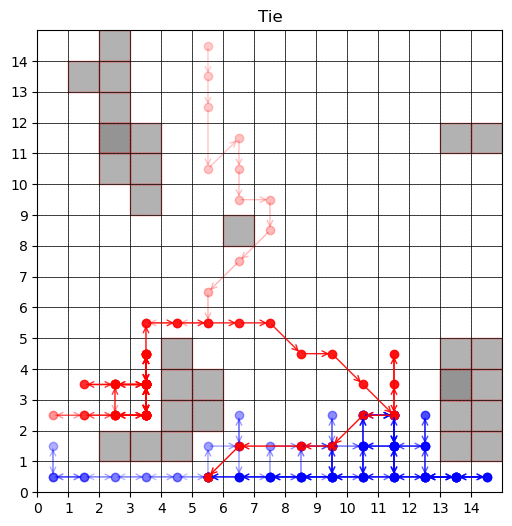

In [89]:
draw_grid(o05, e05, 0)

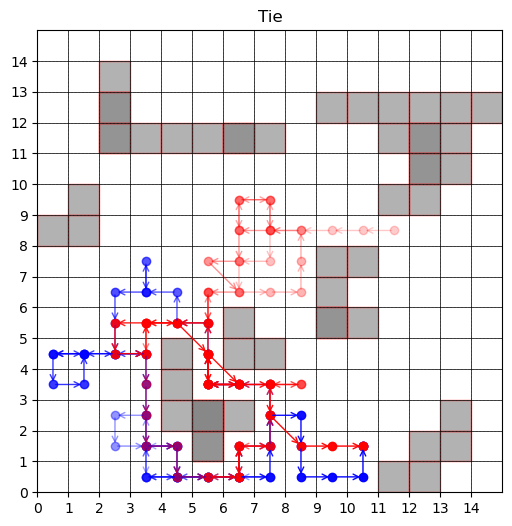

In [90]:
draw_grid(o07, e07, 0)

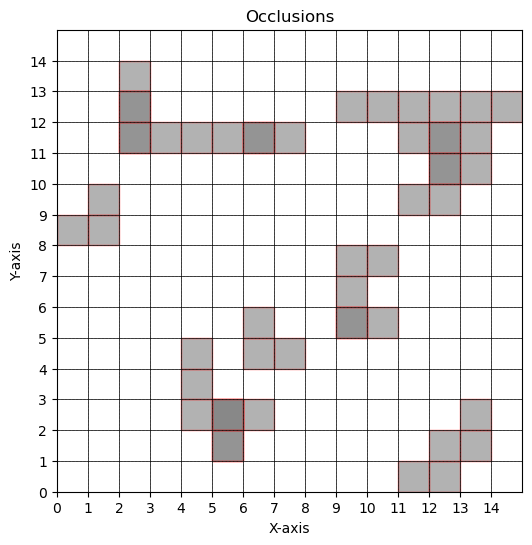

In [51]:
draw_grid(o07, e07, XSize, YSize)